In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
# Why XGBoost?
# Regularization -> reduce overfitting
# Parallel processing -> faster than GBM
# Handle missing values
# Tree pruning -> stop splitting a ndoe when it encounters a negative loss in the split
# Built-in cross-validation

# Load Data

In [2]:
gr = pd.read_csv('official_goodreads_metadata.csv')
gr

,asin,average_rating,ratings_count,reviews_count,text_reviews_count,total_ratings_count,total_reviews_count,total_text_reviews_count,publication_year,publication_month,...,publisher,num_pages,format,description,cleaned_description,gr_countDes_before,gr_countDes_after,cleaned_genres,gr_countText_before,gr_countText_after
0,000100039X,4.23,186297,163625,5535,220088,196528,8847,2010.0,1.0,...,Rupa & Co,127.0,Paperback,"Kahlil Gibran's masterpiece, The Prophet, is o...",tahsil vibrants masterpiece prophet one belove...,106.0,66.0,"poetry, fiction, non-fiction",42320,17834
1,0001053655,4.08,16,33,6,676,1552,85,1997.0,NaN,...,HarperCollins,268.0,Hardcover,NaN,NaN,NaN,NaN,"history, historical fiction, biography, non-fi...",158,75
2,0001061240,4.62,10,22,2,221,603,36,1959.0,12.0,...,Western Publishing Company,324.0,Hardcover,NaN,NaN,NaN,NaN,"poetry, children",49,18
3,000161102X,3.86,33,74,4,2929,5786,75,NaN,NaN,...,NaN,190.0,NaN,The snobby girls at the fashionable boarding s...,snobby girl fashionable board school ridicule ...,47.0,25.0,"children, fiction, young-adult, history, histo...",130,61
4,0001711296,4.29,604,1319,48,738,1564,65,NaN,NaN,...,Random House,63.0,NaN,NaN,NaN,NaN,NaN,"children, fiction, poetry, fantasy, paranormal",257,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312953240,3.80,75,178,8,87,201,8,1995.0,7.0,...,St. Martin's Paperbacks,570.0,Paperback,Recounts the search for and trial of a serial ...,recount search trial serial killer target offr...,41.0,20.0,"mystery, thriller, crime, non-fiction",219,94
37229,0312955138,3.38,27,75,3,29,81,4,1995.0,9.0,...,St. Martin's Paperbacks,320.0,Paperback,"Jill Coit was a voluptuous, dark-skinned beaut...",jill coit voluptuous darkskinned beauty sultry...,156.0,82.0,"mystery, thriller, crime, non-fiction",125,52
37230,0312955154,3.36,52,94,5,56,101,5,1995.0,10.0,...,St. Martin's Press,NaN,Paperback,Paleontologist Cameron Malone has discovered a...,paleontologist cameron alone discover yearly m...,48.0,33.0,"mystery, thriller, crime, fiction",362,184
37231,0312956878,3.78,57,189,3,59,193,4,1995.0,10.0,...,St. Martin's Paperbacks,608.0,Paperback,A KILLER WITHOUT REDEMPTION...\nIn broad dayli...,killer without redemption broad daylight backw...,187.0,103.0,"mystery, thriller, crime, non-fiction",152,76


In [3]:
am = pd.read_csv('official_amazon_metadata.csv')
am

,asin,average,rating_count,text_reviews_count,genres,rank,verifiedTrue_count,Format,am_countText_before,am_countText_after
0,0001713353,4.83,54,54,"Childrens Books, Literature & Fiction",1461315,36,"Paperback, Hardcover",2362,1037
1,0001061240,4.87,45,45,"Childrens Books, Literature & Fiction",321557,30,Hardcover,3085,1326
2,0001711296,4.44,107,107,Literature & Fiction,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574
3,0002007649,3.37,19,19,"Science & Math, Chemistry",9799524,3,"Kindle Edition, Paperback, Hardcover",5668,2810
4,0001716069,4.61,59,59,"Literature & Fiction, Poetry",3841172,44,"Kindle Edition, Paperback, Hardcover",3081,1457
...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,4.17,24,24,"Literature & Fiction, Fiction",2583900,9,"Mass Market Paperback, Kindle Edition",5228,2508
37229,0312953038,4.00,27,27,"Romance, Historical",553268,12,"Mass Market Paperback, Kindle Edition, Pape...",3184,1420
37230,0312955154,3.29,14,14,"Literature & Fiction, Fiction",3412599,4,"Kindle Edition, Paperback",1456,683
37231,0312956878,3.33,15,15,"Biographies & Memoirs, True Crime",2606128,9,"Mass Market Paperback, Hardcover",968,450


In [4]:
am_gr = pd.merge(gr[['asin', 'average_rating', 'total_ratings_count', 'total_reviews_count', 'total_text_reviews_count',
                    'publication_year', 'publication_month', 'publication_day', 'num_pages', 'format', 'gr_countDes_before',
                    'gr_countDes_after', 'cleaned_genres', 'gr_countText_before', 'gr_countText_after']],
                 am[['asin', 'average', 'rating_count', 'text_reviews_count', 'rank', 'verifiedTrue_count', 'Format',
                    'am_countText_before', 'am_countText_after']], how='inner', on='asin')
am_gr

,asin,average_rating,total_ratings_count,total_reviews_count,total_text_reviews_count,publication_year,publication_month,publication_day,num_pages,format,...,gr_countText_before,gr_countText_after,average,rating_count,text_reviews_count,rank,verifiedTrue_count,Format,am_countText_before,am_countText_after
0,000100039X,4.23,220088,196528,8847,2010.0,1.0,1.0,127.0,Paperback,...,42320,17834,4.64,1453,1453,1810945,1130,NaN,69909,31772
1,0001053655,4.08,676,1552,85,1997.0,NaN,NaN,268.0,Hardcover,...,158,75,4.48,50,50,9799161,43,"Kindle Edition, Paperback, Hardcover, Audi...",4888,2240
2,0001061240,4.62,221,603,36,1959.0,12.0,1.0,324.0,Hardcover,...,49,18,4.87,45,45,321557,30,Hardcover,3085,1326
3,000161102X,3.86,2929,5786,75,NaN,NaN,NaN,190.0,NaN,...,130,61,4.35,17,17,1542999,13,NaN,788,399
4,0001711296,4.29,738,1564,65,NaN,NaN,NaN,63.0,NaN,...,257,117,4.44,107,107,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312953240,3.80,87,201,8,1995.0,7.0,15.0,570.0,Paperback,...,219,94,3.69,13,13,443719,4,"Mass Market Paperback, Hardcover",2599,1216
37229,0312955138,3.38,29,81,4,1995.0,9.0,15.0,320.0,Paperback,...,125,52,3.58,12,12,3470182,6,"Kindle Edition, Hardcover",1489,668
37230,0312955154,3.36,56,101,5,1995.0,10.0,15.0,NaN,Paperback,...,362,184,3.29,14,14,3412599,4,"Kindle Edition, Paperback",1456,683
37231,0312956878,3.78,59,193,4,1995.0,10.0,15.0,608.0,Paperback,...,152,76,3.33,15,15,2606128,9,"Mass Market Paperback, Hardcover",968,450


In [5]:
am_gr = am_gr.rename(columns={'average_rating':'gr_rating', 'total_ratings_count':'gr_ratings_count', 
                              'total_reviews_count':'gr_reviews_count', 'total_text_reviews_count':'gr_text_reviews_count',
                              'publication_year':'gr_pub_yr', 'publication_month':'gr_pub_mo', 'publication_day':'gr_pub_day',
                              'num_pages':'gr_num_pages', 'format':'gr_format', 'cleaned_genres':'gr_genres', 
                              'average':'am_rating', 'rating_count':'am_ratings_count', 
                              'text_reviews_count':'am_text_reviews_count', 'rank':'am_rank',
                              'verifiedTrue_count':'am_verifiedTrue_count', 'Format':'am_format'})
am_gr

,asin,gr_rating,gr_ratings_count,gr_reviews_count,gr_text_reviews_count,gr_pub_yr,gr_pub_mo,gr_pub_day,gr_num_pages,gr_format,...,gr_countText_before,gr_countText_after,am_rating,am_ratings_count,am_text_reviews_count,am_rank,am_verifiedTrue_count,am_format,am_countText_before,am_countText_after
0,000100039X,4.23,220088,196528,8847,2010.0,1.0,1.0,127.0,Paperback,...,42320,17834,4.64,1453,1453,1810945,1130,NaN,69909,31772
1,0001053655,4.08,676,1552,85,1997.0,NaN,NaN,268.0,Hardcover,...,158,75,4.48,50,50,9799161,43,"Kindle Edition, Paperback, Hardcover, Audi...",4888,2240
2,0001061240,4.62,221,603,36,1959.0,12.0,1.0,324.0,Hardcover,...,49,18,4.87,45,45,321557,30,Hardcover,3085,1326
3,000161102X,3.86,2929,5786,75,NaN,NaN,NaN,190.0,NaN,...,130,61,4.35,17,17,1542999,13,NaN,788,399
4,0001711296,4.29,738,1564,65,NaN,NaN,NaN,63.0,NaN,...,257,117,4.44,107,107,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312953240,3.80,87,201,8,1995.0,7.0,15.0,570.0,Paperback,...,219,94,3.69,13,13,443719,4,"Mass Market Paperback, Hardcover",2599,1216
37229,0312955138,3.38,29,81,4,1995.0,9.0,15.0,320.0,Paperback,...,125,52,3.58,12,12,3470182,6,"Kindle Edition, Hardcover",1489,668
37230,0312955154,3.36,56,101,5,1995.0,10.0,15.0,NaN,Paperback,...,362,184,3.29,14,14,3412599,4,"Kindle Edition, Paperback",1456,683
37231,0312956878,3.78,59,193,4,1995.0,10.0,15.0,608.0,Paperback,...,152,76,3.33,15,15,2606128,9,"Mass Market Paperback, Hardcover",968,450


In [6]:
am_gr['rating_diff'] = am_gr['gr_rating'] - am_gr['am_rating']
am_gr['ratings_count'] = am_gr['gr_ratings_count'] + am_gr['am_ratings_count']
am_gr['text_reviews_count'] = am_gr['gr_text_reviews_count'] + am_gr['am_text_reviews_count']
am_gr = am_gr.drop('gr_ratings_count', axis=1)
am_gr = am_gr.drop('gr_reviews_count', axis=1)
am_gr = am_gr.drop('gr_text_reviews_count', axis=1)
am_gr = am_gr.drop('am_ratings_count', axis=1)
am_gr = am_gr.drop('am_text_reviews_count', axis=1)
am_gr = am_gr.drop('gr_rating', axis=1)
am_gr = am_gr.drop('am_rating', axis=1)
am_gr

,asin,gr_pub_yr,gr_pub_mo,gr_pub_day,gr_num_pages,gr_format,gr_countDes_before,gr_countDes_after,gr_genres,gr_countText_before,gr_countText_after,am_rank,am_verifiedTrue_count,am_format,am_countText_before,am_countText_after,rating_diff,ratings_count,text_reviews_count
0,000100039X,2010.0,1.0,1.0,127.0,Paperback,106.0,66.0,"poetry, fiction, non-fiction",42320,17834,1810945,1130,NaN,69909,31772,-0.41,221541,10300
1,0001053655,1997.0,NaN,NaN,268.0,Hardcover,NaN,NaN,"history, historical fiction, biography, non-fi...",158,75,9799161,43,"Kindle Edition, Paperback, Hardcover, Audi...",4888,2240,-0.40,726,135
2,0001061240,1959.0,12.0,1.0,324.0,Hardcover,NaN,NaN,"poetry, children",49,18,321557,30,Hardcover,3085,1326,-0.25,266,81
3,000161102X,NaN,NaN,NaN,190.0,NaN,47.0,25.0,"children, fiction, young-adult, history, histo...",130,61,1542999,13,NaN,788,399,-0.49,2946,92
4,0001711296,NaN,NaN,NaN,63.0,NaN,NaN,NaN,"children, fiction, poetry, fantasy, paranormal",257,117,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574,-0.15,845,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312953240,1995.0,7.0,15.0,570.0,Paperback,41.0,20.0,"mystery, thriller, crime, non-fiction",219,94,443719,4,"Mass Market Paperback, Hardcover",2599,1216,0.11,100,21
37229,0312955138,1995.0,9.0,15.0,320.0,Paperback,156.0,82.0,"mystery, thriller, crime, non-fiction",125,52,3470182,6,"Kindle Edition, Hardcover",1489,668,-0.20,41,16
37230,0312955154,1995.0,10.0,15.0,NaN,Paperback,48.0,33.0,"mystery, thriller, crime, fiction",362,184,3412599,4,"Kindle Edition, Paperback",1456,683,0.07,70,19
37231,0312956878,1995.0,10.0,15.0,608.0,Paperback,187.0,103.0,"mystery, thriller, crime, non-fiction",152,76,2606128,9,"Mass Market Paperback, Hardcover",968,450,0.45,74,19


# All Numerical Features

In [7]:
X =  am_gr[['gr_pub_yr', 'gr_pub_mo', 'gr_pub_day', 'gr_num_pages', 'gr_countDes_before', 'gr_countDes_after', 
            'gr_countText_before', 'gr_countText_after', 'am_rank', 'am_verifiedTrue_count', 'am_countText_before',
            'am_countText_after', 'ratings_count', 'text_reviews_count']]
Y = am_gr['rating_diff']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.1758624183905789
Mean Squared Error: 0.055545754399098014
Root Mean Squared Error: 0.23568146808584253
R2 Score: 0.5054089081075587
TEST DATA:
Mean Absolute Error: 0.23514974529049887
Mean Squared Error: 0.10295239633751332
Root Mean Squared Error: 0.32086195838321707
R2 Score: 0.0869446891479787


In [8]:
# Using k-fold cross-validation
params = {}
data_dmatrix = xgb.DMatrix(data=X,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)

In [9]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.701433,0.000720,0.702612,0.003269
1,0.539002,0.000620,0.541590,0.003545
2,0.437009,0.000649,0.441307,0.003707
3,0.375951,0.000705,0.382305,0.003779
4,0.340944,0.000769,0.349296,0.003839
5,0.321618,0.000687,0.331747,0.004047
6,0.310670,0.000770,0.322480,0.003698
7,0.304394,0.000660,0.317793,0.003983
8,0.300461,0.000743,0.315241,0.004018
9,0.298193,0.000784,0.314091,0.004039


In [10]:
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
21         0.285528        0.001148        0.312157        0.00348


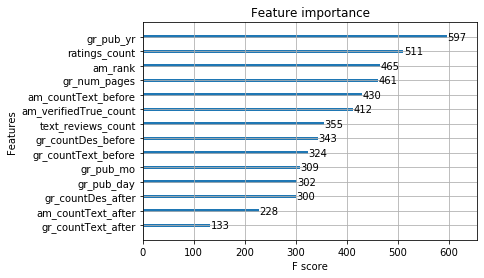

In [11]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Let's try again with just 8 most important features.

# 6 Most Important Numerical Features

In [13]:
X =  am_gr[['gr_pub_yr', 'am_rank', 'gr_num_pages', 'ratings_count', 'am_countText_before', 'am_verifiedTrue_count']]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.18984685906198778
Mean Squared Error: 0.06571837285596405
Root Mean Squared Error: 0.25635594952324403
R2 Score: 0.41482977160260426
TEST DATA:
Mean Absolute Error: 0.23606566499672588
Mean Squared Error: 0.10371779028532777
Root Mean Squared Error: 0.3220524651129498
R2 Score: 0.08015662948344304


In [14]:
# Using k-fold cross-validation
params = {}
data_dmatrix = xgb.DMatrix(data=X,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
17           0.2963        0.000308        0.313918       0.003629


Slightly worse but not bad. Worth keeping.

# Adding Categorical Variables

### Adding gr_format

In [15]:
df = pd.get_dummies(am_gr['gr_format'].str.strip().str.lower())
df = pd.concat([df, am_gr['asin']], axis=1)
df = pd.merge(df, am_gr[['asin', 'gr_pub_yr', 'am_rank', 'gr_num_pages', 'ratings_count', 'am_countText_before',
                         'am_verifiedTrue_count']], how='right', on='asin')
df

,audible audio,audio,audio cassette,audio cd,audio cd (unabridged),audiobook,b,big book,board book,boxed set - hardcover,...,trade paperback,unbound,unknown binding,asin,gr_pub_yr,am_rank,gr_num_pages,ratings_count,am_countText_before,am_verifiedTrue_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,000100039X,2010.0,1810945,127.0,221541,69909,1130
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0001053655,1997.0,9799161,268.0,726,4888,43
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0001061240,1959.0,321557,324.0,266,3085,30
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,000161102X,NaN,1542999,190.0,2946,788,13
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0001711296,NaN,2884610,63.0,845,5667,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312953240,1995.0,443719,570.0,100,2599,4
37229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312955138,1995.0,3470182,320.0,41,1489,6
37230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312955154,1995.0,3412599,NaN,70,1456,4
37231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312956878,1995.0,2606128,608.0,74,968,9


In [16]:
df = df.drop('asin', axis=1)
df.columns

Index(['audible audio', 'audio', 'audio cassette', 'audio cd',
       'audio cd (unabridged)', 'audiobook', 'b', 'big book', 'board book',
       'boxed set - hardcover', 'broschiert', 'cards', 'cd-rom', 'cloth',
       'ebook', 'hardback', 'hardcover', 'hardcover slipcase',
       'hardcover, ebook', 'kindle', 'kindle edition', 'leather bound',
       'library binding', 'mass market paperback',
       'mixed media product - hardcover and cds', 'nook', 'novelty book',
       'other format', 'paper', 'paperback', 'paperback + 2 cds',
       'paperback boxed set', 'softback', 'softcover',
       'spiral binding in hardcover', 'spiral-bound', 'trade paperback',
       'unbound', 'unknown binding', 'gr_pub_yr', 'am_rank', 'gr_num_pages',
       'ratings_count', 'am_countText_before', 'am_verifiedTrue_count'],
      dtype='object')

In [17]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.19613659035530254
Mean Squared Error: 0.0711551170050963
Root Mean Squared Error: 0.26674916495669915
R2 Score: 0.3664198570348973
TEST DATA:
Mean Absolute Error: 0.2347067205792455
Mean Squared Error: 0.10226611975464751
Root Mean Squared Error: 0.3197907436975741
R2 Score: 0.09303107956714662


In [18]:
# Using k-fold cross-validation
params = {}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
16         0.296747          0.0008        0.313918       0.003535


Slightly better than the last one

### Adding gr_genres

In [29]:
am_gr['gr_genres'] = am_gr['gr_genres'].str.replace(' ','')

In [30]:
df = pd.get_dummies(am_gr['gr_genres'].str.get_dummies(sep=','))
df = pd.concat([df, am_gr['asin']], axis=1)
df = pd.merge(df, am_gr[['asin', 'gr_pub_yr', 'am_rank', 'gr_num_pages', 'ratings_count', 'am_countText_before', 
                         'am_verifiedTrue_count']], how='right', on='asin')
df

,biography,children,comics,crime,fantasy,fiction,graphic,historicalfiction,history,mystery,...,romance,thriller,young-adult,asin,gr_pub_yr,am_rank,gr_num_pages,ratings_count,am_countText_before,am_verifiedTrue_count
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,000100039X,2010.0,1810945,127.0,221541,69909,1130
1,1,0,1,0,0,1,1,1,1,0,...,0,0,0,0001053655,1997.0,9799161,268.0,726,4888,43
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0001061240,1959.0,321557,324.0,266,3085,30
3,1,1,0,0,0,1,0,1,1,0,...,1,0,1,000161102X,NaN,1542999,190.0,2946,788,13
4,0,1,0,0,1,1,0,0,0,0,...,0,0,0,0001711296,NaN,2884610,63.0,845,5667,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0312953240,1995.0,443719,570.0,100,2599,4
37229,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0312955138,1995.0,3470182,320.0,41,1489,6
37230,0,0,0,1,0,1,0,0,0,1,...,0,1,0,0312955154,1995.0,3412599,NaN,70,1456,4
37231,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0312956878,1995.0,2606128,608.0,74,968,9


In [31]:
df = df.drop('asin', axis=1)
df.columns

Index(['biography', 'children', 'comics', 'crime', 'fantasy', 'fiction',
       'graphic', 'historicalfiction', 'history', 'mystery', 'non-fiction',
       'paranormal', 'poetry', 'romance', 'thriller', 'young-adult',
       'gr_pub_yr', 'am_rank', 'gr_num_pages', 'ratings_count',
       'am_countText_before', 'am_verifiedTrue_count'],
      dtype='object')

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.18410400656096626
Mean Squared Error: 0.06216740088964551
Root Mean Squared Error: 0.24933391443934277
R2 Score: 0.44644837361999723
TEST DATA:
Mean Absolute Error: 0.23140832961828575
Mean Squared Error: 0.10083450511095969
Root Mean Squared Error: 0.31754449312019206
R2 Score: 0.10572765973442522


In [33]:
# Using k-fold cross-validation
params = {}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
18         0.289659        0.001004         0.30893       0.004106


Slightly better than the model w/o categorical

### Adding am_format

In [39]:
am_gr['am_format'] = am_gr['am_format'].str.replace(' ','')

In [40]:
df = pd.get_dummies(am_gr['am_format'].str.get_dummies(sep=','))
df = pd.concat([df, am_gr['asin']], axis=1)
df = pd.merge(df, am_gr[['asin', 'gr_pub_yr', 'am_rank', 'gr_num_pages', 'ratings_count', 'am_countText_before', 
                         'am_verifiedTrue_count']], how='right', on='asin')
df

,Accessory,AmazonVideo,AudibleAudiobook,AudioCD,AudioCDLibraryBinding,AudioCassette,BargainBook,BathBook,Blu-ray,Boardbook,...,VHSTape,Vinyl,VinylBound,asin,gr_pub_yr,am_rank,gr_num_pages,ratings_count,am_countText_before,am_verifiedTrue_count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,000100039X,2010.0,1810945,127.0,221541,69909,1130
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0001053655,1997.0,9799161,268.0,726,4888,43
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0001061240,1959.0,321557,324.0,266,3085,30
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,000161102X,NaN,1542999,190.0,2946,788,13
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0001711296,NaN,2884610,63.0,845,5667,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312953240,1995.0,443719,570.0,100,2599,4
37229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312955138,1995.0,3470182,320.0,41,1489,6
37230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312955154,1995.0,3412599,NaN,70,1456,4
37231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0312956878,1995.0,2606128,608.0,74,968,9


In [41]:
df = df.drop('asin', axis=1)
df.columns

Index(['Accessory', 'AmazonVideo', 'AudibleAudiobook', 'AudioCD',
       'AudioCDLibraryBinding', 'AudioCassette', 'BargainBook', 'BathBook',
       'Blu-ray', 'Boardbook', 'BondedLeather', 'CD-ROM', 'Calendar',
       'CardBook', 'Cards', 'Comic', 'DVD', 'DVD-ROM', 'DVDAudio', 'Diary',
       'Digital', 'Diskette', 'Flexibound', 'Hardcover', 'Hardcover-spiral',
       'HardcoverComic', 'Home', 'ImitationLeather', 'Journal',
       'KindleEdition', 'KindleEditionwithAudio/Video', 'Kitchen',
       'LeatherBound', 'LibraryBinding', 'LooseLeaf', 'MP3CD',
       'MP3CDLibraryBinding', 'MP3Music', 'Map', 'MassMarketPaperback',
       'Misc.', 'Misc.Supplies', 'OfficeProduct', 'Pamphlet', 'Paperback',
       'PerfectPaperback', 'PlasticComb', 'Pop-Up',
       'PreloadedDigitalAudioPlayer', 'PrintedAccessCode',
       'PrintonDemand(Paperback)', 'RagBook', 'Ring-bound', 'Roughcut',
       'School&LibraryBinding', 'School&amp;LibraryBinding', 'Sheetmusic',
       'SingleIssueMagazine', 'Spira

In [42]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.19159187153286997
Mean Squared Error: 0.06712642759396566
Root Mean Squared Error: 0.2590876832154814
R2 Score: 0.402292155760558
TEST DATA:
Mean Absolute Error: 0.23280652577670358
Mean Squared Error: 0.10177132278962452
Root Mean Squared Error: 0.31901617951073347
R2 Score: 0.09741929210788847


In [43]:
# Using k-fold cross-validation
params = {}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
20         0.293394        0.000637        0.312092       0.003858


Not as good as gr_genres!

# Hyperparameter Tuning

In [44]:
df = pd.get_dummies(am_gr['gr_genres'].str.get_dummies(sep=','))
df = pd.concat([df, am_gr['asin']], axis=1)
df = pd.merge(df, am_gr[['asin', 'gr_pub_yr', 'am_rank', 'gr_num_pages', 'ratings_count', 'am_countText_before', 
                         'am_verifiedTrue_count']], how='right', on='asin')
df = df.drop('asin', axis=1)
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=.25, random_state=0)

### eta

In [45]:
# Using k-fold cross-validation
params = {'eta':0.1}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.290263        0.000634        0.307919       0.003839


In [46]:
# Using k-fold cross-validation
params = {'eta':0.2}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
34         0.287037        0.000708        0.308288       0.003958


In [47]:
# Using k-fold cross-validation
params = {'eta':0.4}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
14          0.29059         0.00124        0.310251       0.004666


In [50]:
# Using k-fold cross-validation
params = {'eta':0.05}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.306073        0.000858        0.316979       0.004039


Best eta = 0.1

### min_child_weight

In [51]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':5}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.291096        0.000787        0.308014       0.003694


In [53]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':10}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.292344         0.00092        0.307614       0.003633


In [54]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':25}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49          0.29379        0.001066        0.307554       0.003526


### lambda

In [55]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':10, 'lambda':0}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.291773        0.001007        0.307645       0.003593


In [56]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':10, 'lambda':0.5}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.292296        0.001034        0.307702       0.003412


### tree_method

In [60]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':10, 'lambda':0.5, 'tree_method':'exact'}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.292296        0.001034        0.307702       0.003412


In [61]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':10, 'lambda':0.5, 'tree_method':'approx'}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.292411        0.000936        0.307312       0.003756


In [62]:
# Using k-fold cross-validation
params = {'eta':0.1, 'min_child_weight':10, 'lambda':0.5, 'tree_method':'hist'}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
49         0.292031        0.000844        0.307582        0.00363


### Cross-validation tuning

In [63]:
# Using k-fold cross-validation
params = {'eta':0.2, 'min_child_weight':25, 'lambda':0.5, 'tree_method':'approx'}
data_dmatrix = xgb.DMatrix(data=df,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1000, early_stopping_rounds=100,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
35         0.290496        0.000907        0.307504       0.003996


Not worth

# RF Models

### All numeric features w/ null rows removed

In [64]:
am_gr_numeric = am_gr[['asin', 'gr_pub_yr', 'gr_pub_mo', 'gr_pub_day', 'gr_num_pages', 'gr_countDes_before', 'gr_countDes_after',
                       'gr_countText_before', 'gr_countText_after', 'am_rank', 'am_verifiedTrue_count', 'am_countText_before',
                       'am_countText_after', 'rating_diff', 'ratings_count', 'text_reviews_count']]

In [65]:
X =  am_gr_numeric.drop('asin', axis=1).drop('rating_diff', axis=1)
Y = am_gr_numeric['rating_diff']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor()
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.1758624183905789
Mean Squared Error: 0.055545754399098014
Root Mean Squared Error: 0.23568146808584253
R2 Score: 0.5054089081075587
TEST DATA:
Mean Absolute Error: 0.23514974529049887
Mean Squared Error: 0.10295239633751332
Root Mean Squared Error: 0.32086195838321707
R2 Score: 0.0869446891479787


Verdict: Worse!

### All numeric features w/ null rows 

In [66]:
am_gr_numeric.isnull().sum()

asin                        0
gr_pub_yr                1445
gr_pub_mo                2012
gr_pub_day               2212
gr_num_pages             1630
gr_countDes_before       1027
gr_countDes_after        1748
gr_countText_before         0
gr_countText_after          0
am_rank                     0
am_verifiedTrue_count       0
am_countText_before         0
am_countText_after          0
rating_diff                 0
ratings_count               0
text_reviews_count          0
dtype: int64

In [67]:
# Fill null values with mean
am_gr_numeric_mean = am_gr_numeric
am_gr_numeric_mean['gr_pub_yr'].fillna(am_gr_numeric_mean['gr_pub_yr'].mean(), inplace=True)
am_gr_numeric_mean['gr_pub_mo'].fillna(am_gr_numeric_mean['gr_pub_mo'].mean(), inplace=True)
am_gr_numeric_mean['gr_pub_day'].fillna(am_gr_numeric_mean['gr_pub_day'].mean(), inplace=True)
am_gr_numeric_mean['gr_num_pages'].fillna(am_gr_numeric_mean['gr_num_pages'].mean(), inplace=True)
am_gr_numeric_mean['gr_countDes_before'].fillna(am_gr_numeric_mean['gr_countDes_before'].mean(), inplace=True)
# If gr_countDes_after value is null, copy the value from gr_countDes_before
am_gr_numeric_mean['gr_countDes_after'] = np.where(am_gr_numeric_mean['gr_countDes_after'].isnull(), am_gr_numeric_mean['gr_countDes_before'], am_gr_numeric_mean['gr_countDes_after'])

C:\Users\Tu Lam\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Tu Lam\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [68]:
X = am_gr_numeric_mean.drop('asin', axis=1).drop('rating_diff', axis=1)
Y = am_gr_numeric_mean['rating_diff']

In [69]:
# Using k-fold cross-validation
params = {'eta':0.2, 'min_child_weight':25, 'lambda':0.5, 'tree_method':'approx'}
data_dmatrix = xgb.DMatrix(data=X,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=1000, early_stopping_rounds=100,
                    metrics="rmse", as_pandas=True, seed=0)
print((cv_results).tail(1))

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
39         0.287466        0.000636        0.310667       0.002973


Verdict: Removing null rows & substitute for mean are both not as good

# Best Model

In [72]:
x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=.25, random_state=0)
# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)
print(model)
# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
print('R2 Score:', r2_score(y_train, y_pred))
# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=6,
             min_child_weight=10, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)
TRAIN DATA:
Mean Absolute Error: 0.20674489497826787
Mean Squared Error: 0.07930926160414985
Root Mean Squared Error: 0.2816190007867897
R2 Score: 0.2938136367337426
TEST DATA:
Mean Absolute Error: 0.22541936579548671
Mean Squared Error: 0.09593333659111487
Root Mean Squared Error: 0.3097310714008442
R2 Score: 0.1491947193233477
